In [9]:
import numpy as np
import math
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import time
import glob,os
import cv2
import scipy.io as sio
from scipy import signal
import csv
import scipy.misc

In [6]:
rx = 100
ry = 24

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


<IPython.core.display.Javascript object>


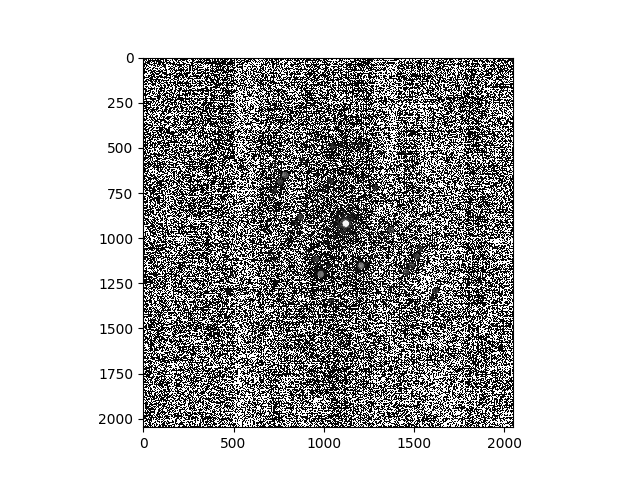

In [64]:
irow = 1
icol = 1
nSample = irow * rx + icol + 1;
Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
plt.imshow(np.sqrt(Sample))

In [92]:
rx = 100
ry = 24
path = '/srv/home/chenyu/DEbackup/120119/S1/'
dataset = np.zeros((ry,rx,500,500))
# PACBED = np.zeros((2048,2048))
for irow in range(ry):
    for icol in range(rx):
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
        Sample[Sample<0] = 0
        Sample_crop = Sample[420:1420,617:1617]
#         PACBED = PACBED + Sample
        resized = cv2.resize(Sample_crop, (500,500), interpolation = cv2.INTER_AREA)
        dataset[irow,icol,:,:] = np.sqrt(resized)

In [114]:
%matplotlib notebook
import hyperspy.api as hs
s = hs.signals.Signal2D(data=dataset)

<IPython.core.display.Javascript object>


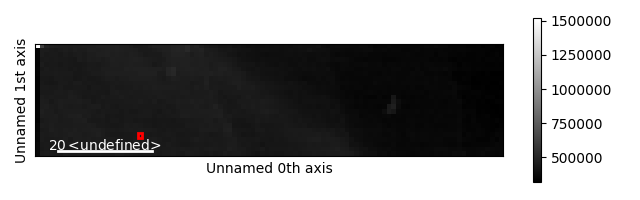

<IPython.core.display.Javascript object>


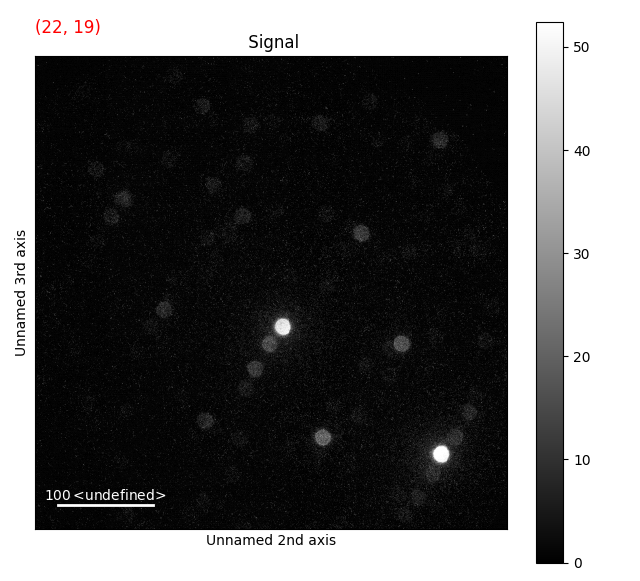

In [115]:
s.plot()

In [8]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy.ndimage import gaussian_filter

<IPython.core.display.Javascript object>


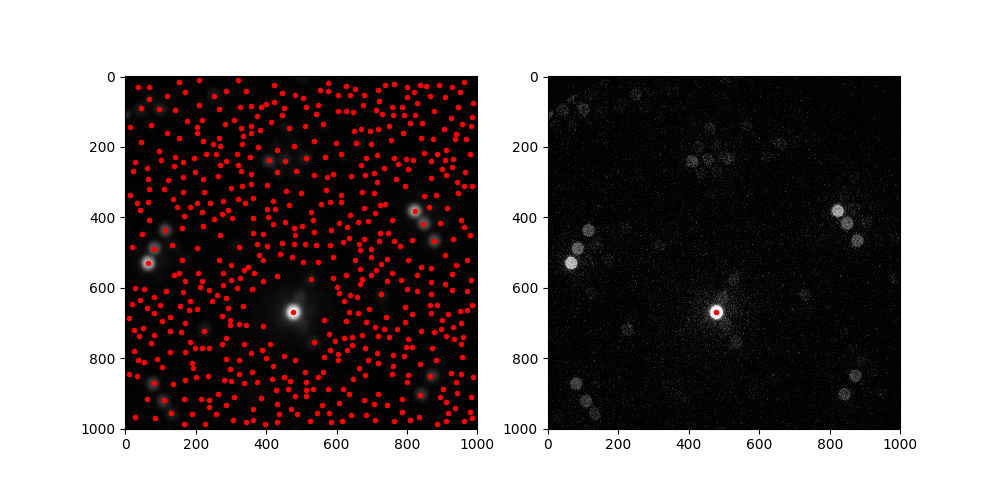

In [31]:
# Test on single frame
irow = 19
icol = 56

if icol==1:
    ref = center_pos[irow-1,icol,:]  # for col=1, take ref point from row on top
else:
    ref = center_pos[irow,icol-1,:]  # for col!=1, take ref point from left side
nSample = irow * rx + icol + 1;
Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
Sample[Sample<0] = 0
Sample_crop = Sample[420:1420,617:1617]
# resized = cv2.resize(Sample, (500,500), interpolation = cv2.INTER_AREA)
resized = Sample_crop
im = np.sqrt(resized)
im = gaussian_filter(im, sigma=6) # Apply Gaussian filter to transfer disk into peak
image_max = ndi.maximum_filter(im, size=50, mode='constant')
coordinates = peak_local_max(im, min_distance=10)
int_list = im[coordinates[:,0],coordinates[:,1]]  # extract intensity for all the peaks
inds = int_list.argsort()[::-1]
coordinates_sorted = coordinates[inds,:]
coordinates_sorted = coordinates_sorted[0:4,:]  # only focus on the first five high intensity disks
dist = np.sqrt(np.sum((coordinates_sorted-ref)**2,axis=1))
coordinates_sorted = coordinates_sorted[dist<50]
center_pos[irow,icol,:] = coordinates_sorted[0,:]

fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.imshow(im)
plt.plot(coordinates[:,1],coordinates[:,0],'r.')
int_list = im[coordinates[:,0],coordinates[:,1]]  # extract intensity for all the peaks
                                                  # Center beam should be among the ones with high intensities

fig.add_subplot(122)
plt.imshow(np.sqrt(resized))
plt.plot(center_pos[irow,icol,1],center_pos[irow,icol,0],'r.')

In [32]:
# Register with center beam, beam stopper was not used, no reference scan necessary

center_pos = np.zeros((ry,rx,2)) # in order of row, col
center_pos[0,1,:] = [500,500]  # insert ref from row=0, col=1, manually picked to make sure zero beam is used
                               # sometimes strong diffracted beam under 2beam condition can be as strong as zero beam
for irow in range(ry):
    for icol in range(1,rx):
        if irow==0 and icol==1:
#             print(irow,icol,ref)
            continue  # skip the original point
        if icol==1:
            ref = center_pos[irow-1,icol,:]  # for col=1, take ref point from row on top
        else:
            ref = center_pos[irow,icol-1,:]  # for col!=1, take ref point from left side
#         print(irow,icol,ref)
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
        Sample[Sample<0] = 0
        Sample_crop = Sample[420:1420,617:1617]
#         resized = cv2.resize(Sample_crop, (500,500), interpolation = cv2.INTER_AREA)
#         im = np.sqrt(resized)
        im = np.sqrt(Sample_crop)
        im = gaussian_filter(im, sigma=6) # Apply Gaussian filter to transfer disk into peak
        image_max = ndi.maximum_filter(im, size=50, mode='constant')
        coordinates = peak_local_max(im, min_distance=10)
        int_list = im[coordinates[:,0],coordinates[:,1]]  # extract intensity for all the peaks
        inds = int_list.argsort()[::-1]
        coordinates_sorted = coordinates[inds,:]  # sort disk coordinates according to descending intensity
        coordinates_sorted = coordinates_sorted[0:4,:]  # only focus on the first five high intensity disks
        dist = np.sqrt(np.sum((coordinates_sorted-ref)**2,axis=1))
        coordinates_sorted = coordinates_sorted[dist<50]  # use disk that is within 50px to the center disk before this frame
        center_pos[irow,icol,:] = coordinates_sorted[0,:]

In [13]:
Sample_crop.shape

(1000, 1000)

<IPython.core.display.Javascript object>


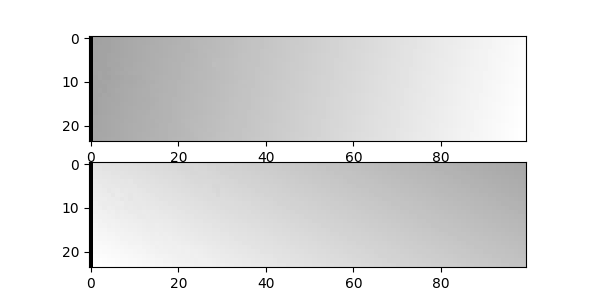

In [33]:
# Plot center point positions to make sure the transition is smooth 
fig = plt.figure(figsize=(6,3))
fig.add_subplot(211)
plt.imshow(center_pos[:,:,0])
fig.add_subplot(212)
plt.imshow(center_pos[:,:,1])

In [34]:
# Run registration with detected center beam positions
dataset_registered = np.zeros((ry,rx,1000,1000))
num_rows, num_cols = dataset_registered.shape[-2:]
for irow in range(ry):
    for icol in range(1,rx):
        nSample = irow * rx + icol + 1;
        Sample = np.load(path+'npy/S1_'+format(nSample,'05')+'.npy')
        Sample[Sample<0] = 0
        # find out relative shift of center position
        x = int(center_pos[irow,icol,1] - center_pos[0,1,1])
        y = int(center_pos[irow,icol,0] - center_pos[0,1,0])
        # Move cropped region according to the shift
        Sample_crop = Sample[420+y:1420+y,617+x:1617+x]
#         resized = cv2.resize(Sample_crop, (500,500), interpolation = cv2.INTER_AREA)
        im = np.sqrt(Sample_crop)
        dataset_registered[irow,icol,:,:] = im
       
#         translation_matrix = np.float32([[1,0,-x],[0,1,-y]])
#         dataset_registered[irow,icol,:,:] = cv2.warpAffine(im, translation_matrix, (num_cols, num_rows))

<IPython.core.display.Javascript object>


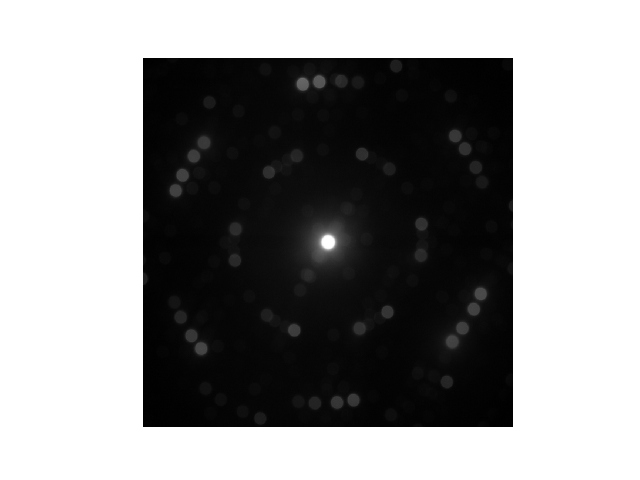

In [35]:
plt.imshow(np.sum(np.sum(np.sqrt(dataset_registered),axis=0),axis=0))
plt.axis('off')
np.save(path + 'Registered_datacube.npy',dataset_registered)

In [6]:
path = '/srv/home/chenyu/DEbackup/2019/120119/S1/'
dataset_registered = np.load(path +  'Registered_datacube.npy')
PACBED = np.sqrt(np.sum(np.sum(np.sqrt(dataset_registered),axis=0),axis=0))

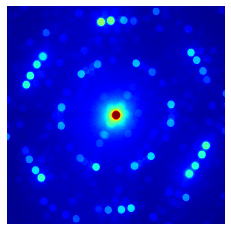

In [12]:
plt.imshow(PACBED,cmap='jet')
plt.axis('off')
plt.imsave('PACBED.tiff', PACBED, cmap='jet')

<IPython.core.display.Javascript object>


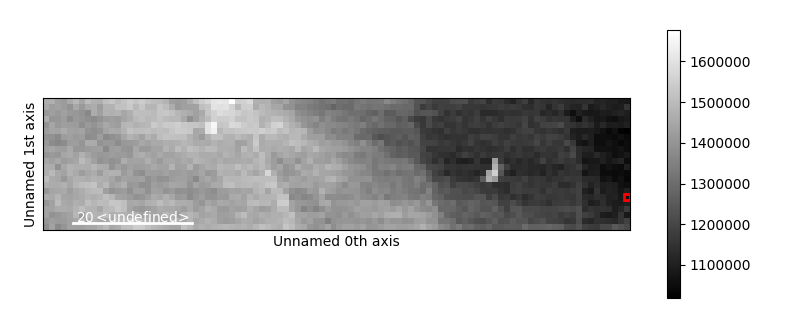

<IPython.core.display.Javascript object>


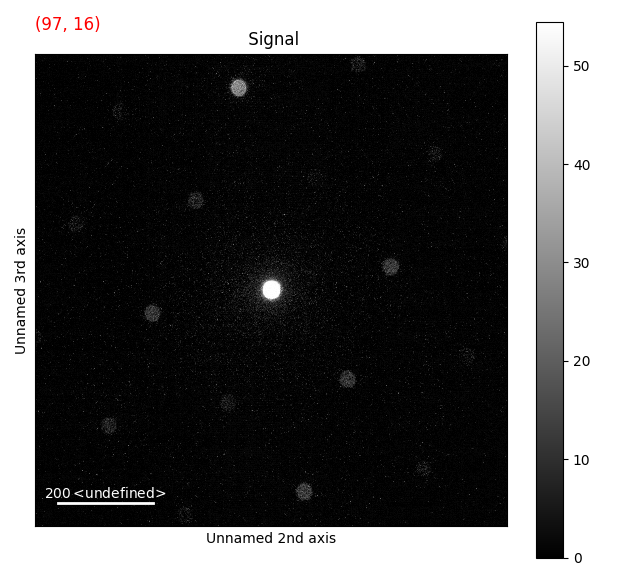

In [4]:
%matplotlib notebook
import hyperspy.api as hs
s = hs.signals.Signal2D(data=dataset_registered[1:-1,1:-1,:,:])
s.plot()

<IPython.core.display.Javascript object>


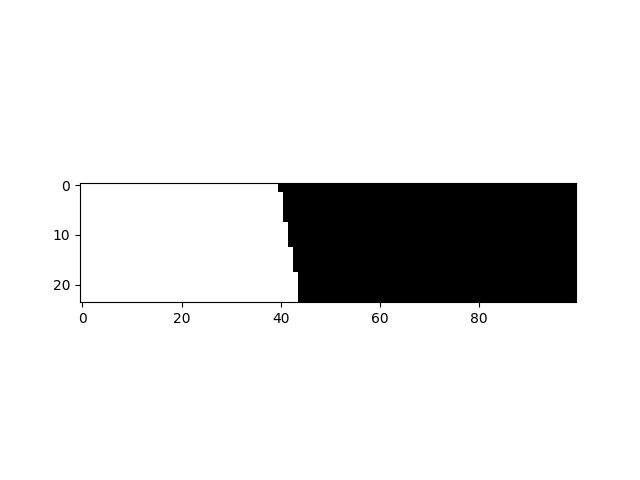

100 24


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:57: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarni

In [36]:
import scipy.misc
# Generate separte PACBED on each layer
# Three straight lines separate region with 4/3/2/1 layers:
# 4/3: y = 5.3x - 210.0
# 3/2: y = 3.5x - 210.0
# 2/1: x = 91
# Generate and save real space BF image
RealSpace = np.sum(np.sum(dataset_registered,axis=3),axis=2)
plt.imshow(np.sqrt(RealSpace))
# scipy.misc.imsave('/srv/home/chenyu/DEbackup/110719/S1/RealSpace.jpg',RealSpace)

# PACBED from the whole field of view
PACBED_registered = np.sum(np.sum(dataset_registered,axis=0),axis=0)
# plt.imshow(np.sqrt(PACBED_registered))
# plt.axis('off')

# generate meshgrid for x and y
ky, kx = RealSpace.shape[0:2]
print(kx, ky)
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
grid_x, grid_y = np.meshgrid(kx,ky)


# 1 layer
PACBED_1 = np.zeros(PACBED_registered.shape[0:2])
PACBED_2 = np.zeros(PACBED_registered.shape[0:2])
PACBED_3 = np.zeros(PACBED_registered.shape[0:2])
PACBED_4 = np.zeros(PACBED_registered.shape[0:2])
mask_1 = grid_x > 90
mask_2 = (grid_y < 3.5 * grid_x - 210.0) & (~mask_1)
mask_3 = (grid_y < 5.3 * grid_x - 210) & (~mask_1) & (~mask_2)
mask_4 = (~mask_3) & (~mask_2) & (~mask_1)
plt.imshow(mask_4)
for irow in range(RealSpace.shape[0]):
    for icol in range(RealSpace.shape[1]):
        if mask_1[irow,icol]==1:
            PACBED_1 = PACBED_1 + dataset_registered[irow,icol,:,:]
        elif mask_2[irow,icol] == 1:
            PACBED_2 = PACBED_2 + dataset_registered[irow,icol,:,:]
        elif mask_3[irow,icol] == 1:
            PACBED_3 = PACBED_3 + dataset_registered[irow,icol,:,:]
        elif mask_4[irow,icol] == 1:
            PACBED_4 = PACBED_4 + dataset_registered[irow,icol,:,:]

# acquired diffractions are flipped LR from real space strucutre
# Actually, precise STEM rotation should also be considered to get a perfect match between x-kx and y-ky
PACBED_1 = np.fliplr(PACBED_1)
PACBED_2 = np.fliplr(PACBED_2)
PACBED_3 = np.fliplr(PACBED_3)
PACBED_4 = np.fliplr(PACBED_4)
            
# save all the PACBEDs
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/RealSpace.jpg',RealSpace)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_whole.jpg',PACBED_registered)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_1layer.jpg',PACBED_1)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_2layer.jpg',PACBED_2)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_3layer.jpg',PACBED_3)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_4layer.jpg',PACBED_4)

scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/RealSpace.jpg',RealSpace)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_whole_sqrt.jpg',np.sqrt(PACBED_registered))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_1layer_sqrt.jpg',np.sqrt(PACBED_1))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_2layer_sqrt.jpg',np.sqrt(PACBED_2))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_3layer_sqrt.jpg',np.sqrt(PACBED_3))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_4layer_sqart.jpg',np.sqrt(PACBED_4))

<IPython.core.display.Javascript object>


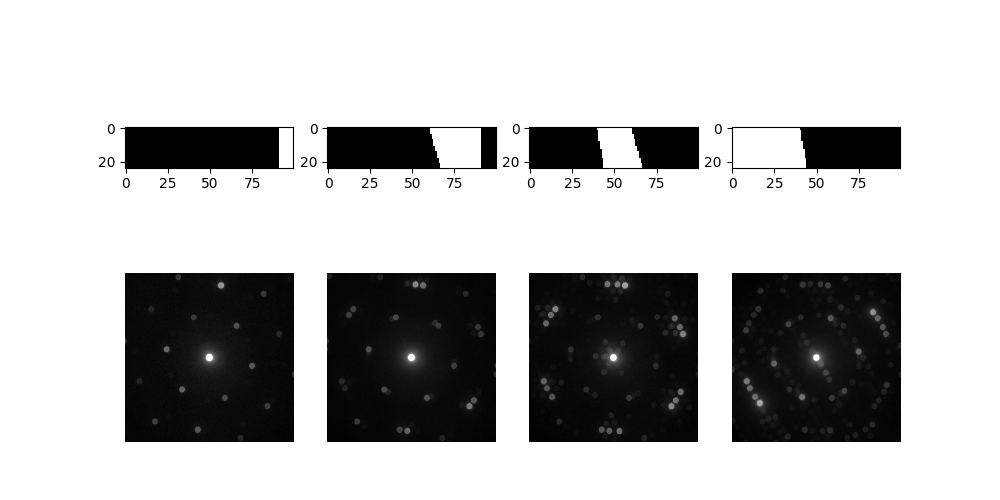

(-0.5, 999.5, 999.5, -0.5)

In [37]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(241)
plt.imshow(mask_1)
# plt.axis('off')

fig.add_subplot(242)
plt.imshow(mask_2)
# plt.axis('off')

fig.add_subplot(243)
plt.imshow(mask_3)
# plt.axis('off')

fig.add_subplot(244)
plt.imshow(mask_4)
# plt.axis('off')

fig.add_subplot(245)
plt.imshow(np.sqrt(PACBED_1))
plt.axis('off')

fig.add_subplot(246)
plt.imshow(np.sqrt(PACBED_2))
plt.axis('off')

fig.add_subplot(247)
plt.imshow(np.sqrt(PACBED_3))
plt.axis('off')

fig.add_subplot(248)
plt.imshow(np.sqrt(PACBED_4))
plt.axis('off')


In [38]:
import scipy.misc
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_1layer_sqrt.tiff',np.sqrt(PACBED_1))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_2layers_sqrt.tiff',np.sqrt(PACBED_2))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_3layers_sqrt.tiff',np.sqrt(PACBED_3))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_4layers_sqrt.tiff',np.sqrt(PACBED_4))
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_whole_sqrt.tiff',np.sqrt(PACBED_registered))

scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_1layer.tiff',PACBED_1)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_2layers.tiff',PACBED_2)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_3layers.tiff',PACBED_3)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_4layers.tiff',PACBED_4)
scipy.misc.imsave('/srv/home/chenyu/DEbackup/120119/S1/PACBED_whole.tiff',PACBED_registered)

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``im

<IPython.core.display.Javascript object>


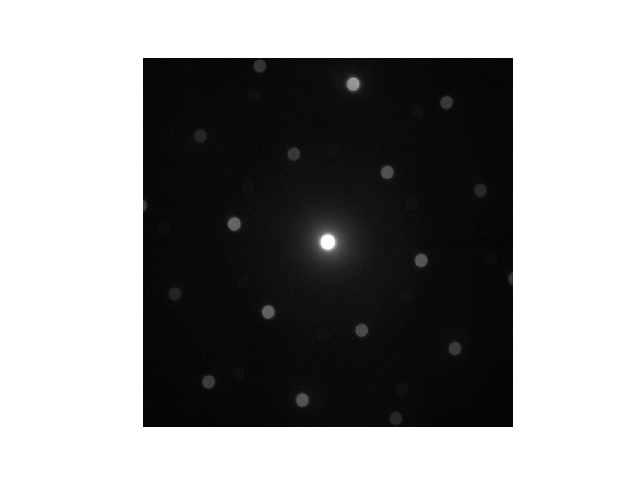

(-0.5, 999.5, 999.5, -0.5)

In [39]:
plt.imshow(np.sqrt(PACBED_1))
plt.axis('off')